In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as si
import scipy.special as ss
import scipy.stats as st
from scipy.fftpack import fft, ifft
import utils as u
import profiles as p
import csv
from astropy.modeling import models, fitting
import glob

In [8]:
#list of all .prof files
filenames = glob.glob('./J0332+5434/*.prof')
#list to store profile objects from read in data
profs = []

#read in data, save flux values into numpy array
for i,name in enumerate(filenames):   
    with open (name, 'r') as f:
        data = f.readlines()
        
        #save, then remove first line of metadata
        header = data[0]
        data.remove(data[0])
        
        #remove indexing, newline characters and save to array
        nbins = len(data)
        single_prof = np.zeros(nbins)
        for i in range(nbins):
            single_prof[i] = data[i].split(" ")[1].split('\n')[0]
        
        #Feed info into profile object, append object to data list
        profs.append(p.profile(header, single_prof))

#remove bad data (from visual inspection)
bad_indices = [0,17,20,28,32,33,47,52,55,60,61,62,69,70,71,72,75,76,77,78,79,83]
ct = 0 
for i in bad_indices:
    profs.remove(profs[i-ct]) #i-ct because once remove an element, the total list length reduces by 1
    ct += 1

profs = np.array(profs)

In [5]:
#save MJD array to use in KS test plot
#mjd_arr = np.array([i.MJD for i in profs])
#np.savetxt('J0332_MJD.txt', mjd_arr)

# Phase align in Fourier Domain

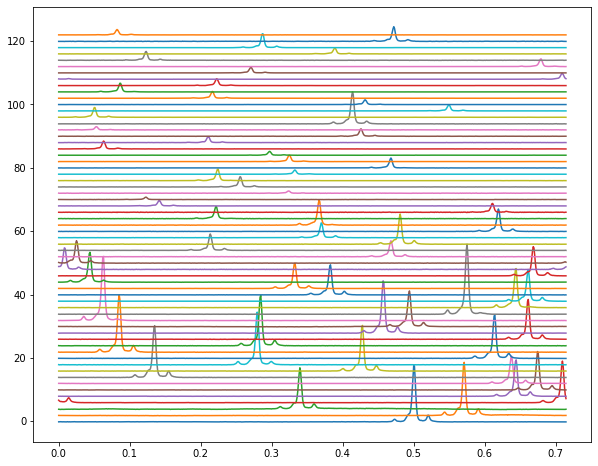

In [9]:
x = profs[0].domain

plt.figure(figsize=(10,8))
for i,val in enumerate(profs):
    plt.plot(x,val.profile - np.mean(val.profile) + i*2)
plt.show()

In [10]:
profs2 = u.phase_shift(profs, basis=2, N=profs[0].nbins, P = profs[0].p)

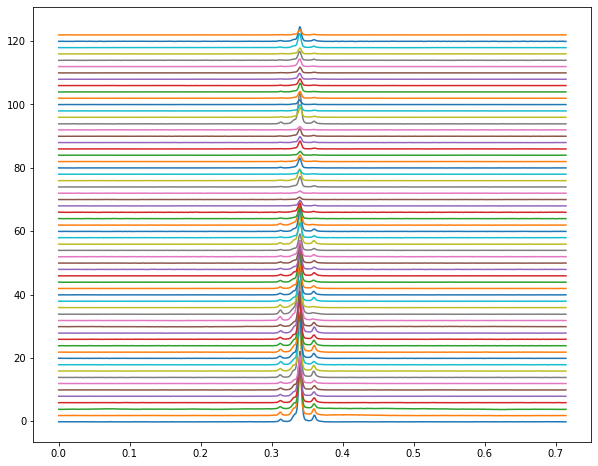

In [11]:
plt.figure(figsize=(10,8))
for i,val in enumerate(profs2):
    plt.plot(x,val.profile - np.mean(val.profile) + i*2)
plt.show()

## Save 2D array into .txt for use in KS_test

# Create Gaussian fit for each profile

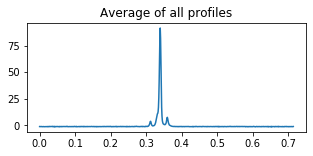

In [31]:
#calib is all the profiles with their means subtracted, so we can compare relative amp
#also normalize data (divide by integral)
#still a 2D array nprof x nbins
calib = []

for i in range(len(profs2)):
    meansub = profs2[i].profile - np.mean(profs2[i].profile) # calibrate all profiles
    calib.append( meansub / np.trapz(meansub)) # normalize
    
calib = np.array(calib)

#save calib to use in KS_test
np.savetxt('J0332_profs.txt', calib)

#avg is the average profile of all 63 profiles
avg = np.average(calib, axis=0)

plt.figure(figsize=(5,2))
plt.plot(x,avg)
plt.title('Average of all profiles')
plt.show()

#can visually see average profile has peaks with mean at ~ .3, .33, .37

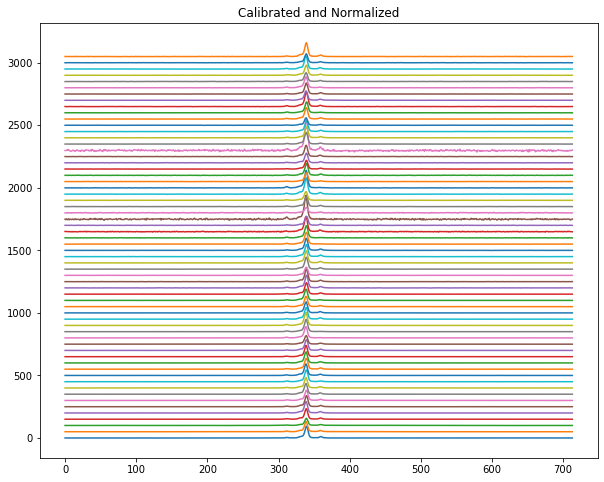

In [46]:
plt.figure(figsize=(10,8))
for i,val in enumerate(calib):
    plt.plot(val + i*50)
plt.title('Calibrated and Normalized')
plt.show()

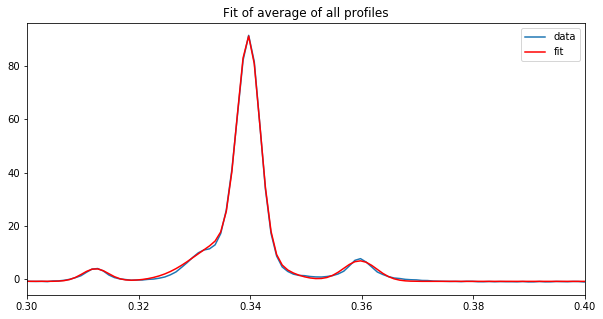

In [32]:
#amp = [1,2.5,17,3]
#mean = [.313, .33, .34, .36]
#stddev = [.003,.001, .003, .0008]

amp = [1, 2.5, 17, 3, .8]
mean = [.313, .33, .34, .36,.34]
stddev = [.002, .001, .003, .0008,.05]

#k = u.gaussian_fit(x, avg,amp, mean, stddev)

g_init = models.Gaussian1D(amplitude=0)
for i in range(len(amp)):
    g_init += models.Gaussian1D(amplitude=amp[i], mean=mean[i], stddev=stddev[i])
fitter = fitting.LevMarLSQFitter()
g = fitter(g_init, x, avg)

plt.figure(figsize=(10,5))
plt.plot(x, avg, label='data')
plt.plot(x, g(x), 'r', label='fit')
plt.title('Fit of average of all profiles')
plt.xlim((.3,.4))
plt.legend()
plt.show()

#res = k(x) - avg
#plt.plot(x,res)
#plt.show()

In [33]:
fitter.fit_info
fitter.fit_info['message']

'Number of calls to function has reached maxfev = 100.'

# Fit all calibrated profiles

In [34]:
g = [] #store fitted object

for i, val in enumerate(calib):
    fitted = u.gaussian_fit(x, val, amp, mean, stddev)
    g.append(fitted)

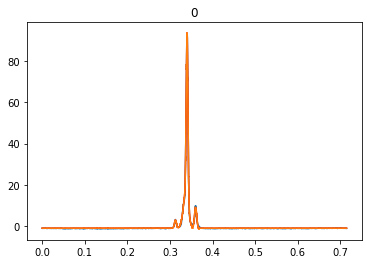

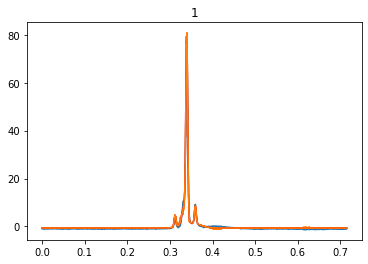

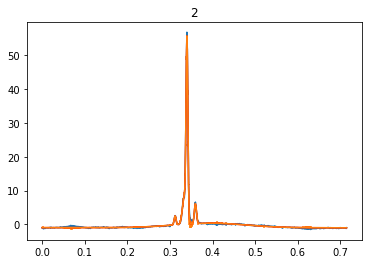

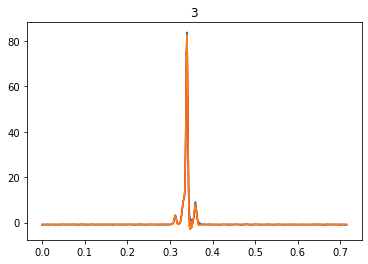

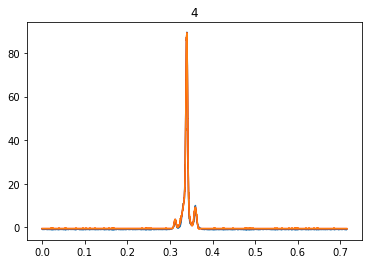

In [36]:
for i,val in enumerate(calib[:5]):
    plt.plot(x, val, label='data')
    plt.plot(x, g[i](x), 'r', label='fit')
    resids = g[i](x) - val
    plt.errorbar(x,g[i](x),yerr=resids)
    plt.title(i)
    plt.show()

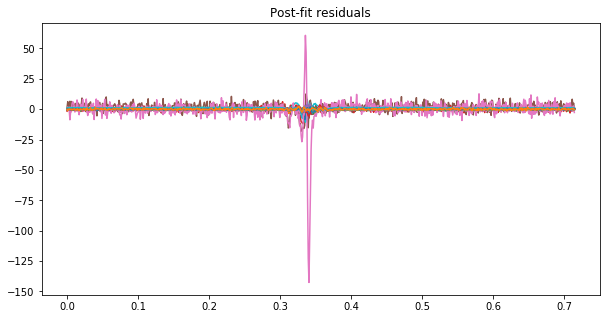

In [37]:
plt.figure(figsize=(10,5))
for i,val in enumerate(calib):
    plt.plot(x,g[i](x) - val)
plt.title('Post-fit residuals')
plt.show()
#do chi square test on residuals

# Fitted params as function of epoch

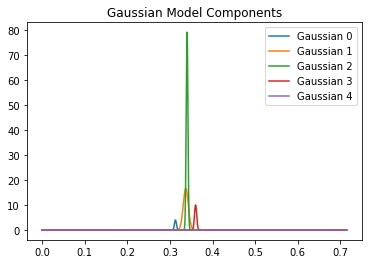

In [48]:
nprofs = len(calib)
domain = [i.MJD for i in profs2]
ngauss = 5

for i in range(ngauss):
    m = models.Gaussian1D(amplitude=g[0].parameters[3*(i+1)], mean=g[0].parameters[3*(i+1)+1], 
                          stddev=g[0].parameters[3*(i+1)+2])
    plt.plot(x, m(x),label='Gaussian %s' %i)
plt.title('Gaussian Model Components')
plt.legend()
plt.show()

## Display errorbars

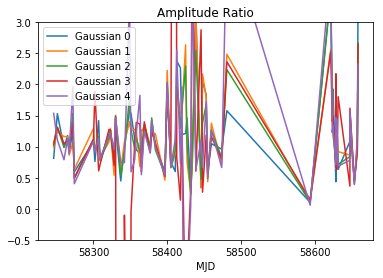

In [12]:
#ratio of amplitude as function of epoch
for i in range(ngauss):
    ratio = []
    for j in range(nprofs-1):#-1 because ratio
        ratio.append(g[j].parameters[3*(i+1)] / g[j+1].parameters[3*(i+1)])
    #domain[1:] because also -1 like ratio, so at each epoch, ratio value = change from this epoch to one b4
    plt.plot(domain[1:], ratio, label='Gaussian %s' %i)
        
plt.legend()
plt.title('Amplitude Ratio')
plt.xlabel('MJD')
plt.ylim(-.5, 3)
plt.show()

## Miscellaneous code

In [15]:
#calculate residuals
#nprofs x nbins 2D array
#resid_tuple = tuple(calib[i] - g[i](x) for i in range(nprofs))
#resids = np.vstack(resid_tuple)
#u.gridplot(resids, 3, figsize=(15,70))

In [ ]:
#ratio of mean as function of epoch
for i in range(ngauss):
    ratio = []
    for j in range(nprofs-1):#-1 because ratio
        ratio.append(g[j].parameters[3*(i+1)+1] / g[j+1].parameters[3*(i+1)+1])
    #domain[1:] because also -1 like ratio, so at each epoch, ratio value = change from this epoch to one b4
    plt.plot(domain[1:], ratio, label='Gaussian %s' %i)
        
plt.legend()
plt.title('Mean Ratio')
plt.xlabel('MJD')
plt.show()

In [ ]:
#ratio of sd as function of epoch
for i in range(ngauss):
    ratio = []
    for j in range(nprofs-1):#-1 because ratio
        ratio.append(g[j].parameters[3*(i+1)+2] / g[j+1].parameters[3*(i+1)+2])
    #domain[1:] because also -1 like ratio, so at each epoch, ratio value = change from this epoch to one b4
    plt.plot(domain[1:], ratio, label='Gaussian %s' %i)
        
plt.legend()
plt.title('Standard Deviation Ratio')
plt.xlabel('MJD')
plt.ylim(0,1.5)
plt.show()